# Decoherence

In the following notebooks, various decay channels will be simulated and
compared to theoretical results. This serves two purposes as it gives a
practical instruction how to simulate various noise sources and it serves
as integration test for the qopt package. The reproduction of theoretically
results also serves as transparent and comprehensible integration test.

Within the next notebooks on decoherence, we will set $\hbar = 1$, measure all
times in milli seconds $\mathrm{ms}$ and all frequencies and energies in
inverse milli seconds $1/ \mathrm{ms}$.

## $T_1$ Depolarization
The depolarization occurs when a qubit relaxes into its ground state. This
behavior is not reversible and hence cannot be described by Schroedinger's
equation which is solved by a unitary propagator. However, we can describe such
dissipative effects using the theory of open quantum systems and describing the
system with a master equation in Lindblad form. A pedagogical introduction
and our examples can be found in these
[lecture notes](https://arxiv.org/abs/1902.00967).

We describe our system with the general master equation in Lindlbad form:

\begin{equation}
\partial_t \rho(t) = -i [H, \rho (t)] + \sum_k \gamma_k
\left( L_k \rho(t) L_k^\dagger-
\frac{1}{2} \{ L_k^\dagger L_k, \rho(t) \} \right)
\end{equation}

In order to discuss a basic depolarization channel, we can
solve the equation for a single qubit with $H=0$,
$L_1 = \sigma_- = \frac{1}{2} (\sigma_x -i \sigma_y)$,
$\gamma_1 = \gamma$ and $\gamma_k = 0 \, \forall \, k >1$. In this case the
equation simplifies to

\begin{equation}
\partial_t \rho(t) =  \gamma (\sigma_- \rho \sigma_+
- \frac{1}{2} \{ \sigma_+ \sigma_-, \rho \} )
\end{equation}

with $\sigma_+ = \sigma_-^\dagger$. The density matrix
of a single qubit can be written as
$\rho = \frac{1}{2} (\mathbb{I} + \vec{v} \cdot \vec{\sigma}) $ and the
solution to the Lindblad equation is:

\begin{align}
v_x(t) &= v_x(0)e^{-\gamma t / 2} \\
v_y(t) &= v_y(0)e^{-\gamma t / 2} \\
v_z(t) &= 1 + [ v_z(0) - 1]e^{-\gamma t }. \\
\end{align}

Let's set the simulation of the qubit governed by the Lindblad master equation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from qopt import *

gamma = .5
n_time_steps = 100
total_time = 10

def prefactor_function(transferred_parameters, _):
    return gamma * np.ones_like(transferred_parameters)

lindblad_solver = LindbladSolver(
    h_drift=[0 * DenseOperator.pauli_x()],
    h_ctrl=[0 * DenseOperator.pauli_z()],
    tau=total_time / n_time_steps * np.ones(n_time_steps),
    prefactor_function=prefactor_function,
    lindblad_operators=[DenseOperator.pauli_m()]
)

fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
lindblad_solver.set_optimization_parameters(fid_ctrl_amps)

The Lindblad master equation is solved by vectorizing the equation and working
with the so called super operator formalism. To change between the super
operator formalism and the usual representation, we define some helper
functions.

In [2]:
def vectorize(rho):
    """Vectorizes a density matrix. """
    d_square = int(rho.shape[0] ** 2)
    return DenseOperator(np.reshape(rho.data.T, (d_square, 1)))

def devectorize(rho_vec):
    """Calculates the regular matrix expression from a vectorized matrix. """
    d = int(np.round(np.sqrt(rho_vec.shape[0])))
    return DenseOperator(np.reshape(rho_vec.data, (d, d)).T)

To reproduce the theoretical description of a $T_1$ process, we start with a
qubit in the excited state $\vert 1 \rangle$ and plot the decay in amplitude.

The T1 time is 2.000000000000001.


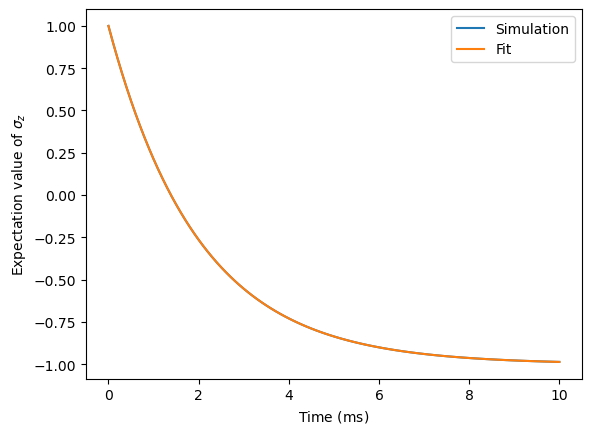

In [3]:
def measure_z(rho):
    """Calculates the expectation values of the sigma_z operator. """
    return np.real((rho * DenseOperator.pauli_z()).tr())

up_state = DenseOperator(np.asarray([[1, 0], [0, 0]]))

propagators = lindblad_solver.forward_propagators
z_projections = [
    measure_z(devectorize(p * vectorize(up_state))) for p in propagators
]

def t1_decay(t, t1):
    return -1 + 2 * np.exp(-1. * t / t1)

popt, pcov = scipy.optimize.curve_fit(
    t1_decay,
    xdata= total_time / n_time_steps * np.arange(n_time_steps + 1),
    ydata=z_projections,
    p0=np.asarray([1 / .5])
)

plt.plot(total_time / n_time_steps * np.arange(n_time_steps + 1),
         z_projections, label='Simulation')
plt.plot(total_time / n_time_steps * np.arange(n_time_steps + 1),
         t1_decay(
             total_time / n_time_steps * np.arange(n_time_steps + 1), *popt
         ), label='Fit')
plt.xlabel('Time ($\mathrm{ms})$')
plt.ylabel('Expectation value of $\sigma_z$')
plt.legend()

print('The T1 time is ' + str(popt[0]) + '.')
plt.show()

We reproduce the theoretical calculation of the T1 time:

\begin{equation}
T_1 = \frac{1}{\gamma}
\end{equation}
